In [1]:
import tensorflow as tf
import numpy as np
import glob
import cv2
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def plotPoke(x):
    f, a = plt.subplots(2, 8, figsize=(8, 2))
    for i in range(8):
        a[0][i].imshow(x[i], cmap=plt.get_cmap('gray'))
        a[0,i].axis('off')
        a[1][i].imshow(x[i+8], cmap=plt.get_cmap('gray'))
        a[1,i].axis('off')
    f.show()
    plt.draw()

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


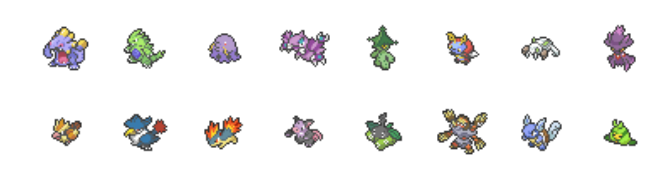

In [3]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 3), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./AE_RGB.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
plotPoke(orig_img)

In [ ]:
# Flat all data to one dimension
X_flat = np.empty((0, 4800), dtype='float32')
for i in xrange(orig_img.shape[0]):
    X_flat = np.append(X_flat, [orig_img[i].reshape(4800)], axis=0)
    
print 'Original image shape:  {0}\nFlatted image shape:  {1}'.format(orig_img.shape, X_flat.shape)

In [4]:
# Transpose RGB channels into 3 different independent image
# Then flatted all pixel into one dimension
X_flat = np.transpose(orig_img, (0,3,1,2))
X_flat = X_flat.reshape(2376, 1600)

print 'Original image shape:  {0}\nFlatted image shape:  {1}'.format(orig_img.shape, X_flat.shape)

Original image shape:  (792, 40, 40, 3)
Flatted image shape:  (2376, 1600)


In [5]:
# Parameters
learning_rate = 0.01
training_epochs = 10000
batch_size = 108
display_step = 500
examples_to_show = 8

# Network Parameters
n_hidden_1 = 1024
n_hidden_2 = 512
n_hidden_3 = 256
n_input = 1600 # Pokemon input (img shape: 40*40)

In [6]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.01)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.01)),
    'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3], stddev=0.01)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2], stddev=0.01)),
    'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=0.01)),
    'decoder_h3': tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev=0.01))
}
biases = {
    'encoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'encoder_b2': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'encoder_b3': tf.Variable(tf.truncated_normal([n_hidden_3], stddev=0.01)),
    'decoder_b1': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'decoder_b2': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'decoder_b3': tf.Variable(tf.truncated_normal([n_input], stddev=0.01))
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                  biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                  biases['encoder_b3']))
    return layer_3

# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    return layer_3

In [7]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the MSE
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [ ]:
sess = tf.InteractiveSession()
sess.run(init)
total_batch = int(X_flat.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size-1
    for i in range(total_batch):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = X_flat[index]
        start = end+1; end = start+batch_size-1
        # Run optimization op (backprop) and loss op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print 'Epoch: {0:04d}   loss: {1:f}'.format(epoch+1, c)

print("Optimization Finished!")

In [ ]:
# Random select some pokemon to visualization
# index are picked in orig_img.shape[0], then transform to X_flat with correspond RGB row
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
index = np.concatenate((index, index+1, index+2))
index = np.sort(index)
autoencoder = sess.run(
    y_pred, feed_dict={X: X_flat[index]})

# merge RGB rows back to RGB matrix
autoencoder = np.reshape(autoencoder, (examples_to_show, 3, 40, 40))
autoencoder = np.transpose(autoencoder, (0,2,3,1))

# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[::3][i]], cmap=plt.get_cmap('gray'))
    a[0,i].axis('off')
    a[1][i].imshow(np.reshape(autoencoder[i], (40, 40)), cmap=plt.get_cmap('gray'))
    a[1,i].axis('off')
f.show()
plt.draw()

In [ ]:
# Save weights and biases
weights_saver = tf.train.Saver(var_list=weights)
biases_saver = tf.train.Saver(var_list=biases)
weights_saver.save(sess, 'AE_weights')
biases_saver.save(sess, 'AE_biases')

In [ ]:
if False:
    index_in_epoch=0, epochs_completed=0
    def next_batch(data, batch_size):
        """Return the next `batch_size` examples from this data set."""
        num_examples = data.shape[0]
        start = index_in_epoch
        index_in_epoch += batch_size
        if index_in_epoch > num_examples:
            # Finished epoch
            epochs_completed += 1
            # Shuffle the data
            perm = np.arange(num_examples)
            np.random.shuffle(perm)
            images = data[perm]
            # Start next epoch
            start = 0
            index_in_epoch = batch_size
            assert batch_size <= num_examples
        end = index_in_epoch
        return data[start:end]

In [ ]:
# Convert RGBA to RGB
path = os.path.abspath("./VAE.ipynb")
path = re.sub('[a-zA-Z\s.]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    newName = re.sub('.png', '', pic)
    Image.open(pic).convert('RGB').save(newName+'_RGB.png')

In [ ]:
# Since imread from plt will output array within 0 and 1, No need to normalize.
if False:
    # Create an empty array to store normalized pokemon pics
    norm_img = np.empty((0, 40, 40, 3), dtype='float32')
    # Normalize data by each channel using easier way (X-mean)/std
    for pic in glob.glob(path+'Pokemon_result/*.bmp'):
        img = cv2.imread(pic)
        # cv2 save img as BGR, plt shows img as RGB
        img = img[:,:,[2,1,0]]
        norm_img = np.append(norm_img, [img], axis=0)
    R_mean = np.mean(norm_img[:,:,:,0]); R_std = np.std(norm_img[:,:,:,0])
    G_mean = np.mean(norm_img[:,:,:,1]); G_std = np.std(norm_img[:,:,:,1])
    B_mean = np.mean(norm_img[:,:,:,2]); B_std = np.std(norm_img[:,:,:,2])
    norm_img[:,:,:,0] = (norm_img[:,:,:,0]-R_mean)/R_std
    norm_img[:,:,:,1] = (norm_img[:,:,:,1]-G_mean)/G_std
    norm_img[:,:,:,2] = (norm_img[:,:,:,2]-B_mean)/B_std  

    # Use plt to show original images 
    plotPoke(norm_img)

In [17]:
a = np.array([[[1,222],[2,333],[3,444],[4,555]],[[5,666],[6,777],[7,888],[8,999]],[[9,121],[0,132],[11,432],[12,543]]])
print a.shape
print a
a = np.transpose(a, (2,0,1))
a = np.reshape(a, (2, 12))
print a
b = a
b = np.reshape(b, (2, 3, 4))
b = np.transpose(b, (1,2,0))
print b

(3, 4, 2)
[[[  1 222]
  [  2 333]
  [  3 444]
  [  4 555]]

 [[  5 666]
  [  6 777]
  [  7 888]
  [  8 999]]

 [[  9 121]
  [  0 132]
  [ 11 432]
  [ 12 543]]]
[[  1   2   3   4   5   6   7   8   9   0  11  12]
 [222 333 444 555 666 777 888 999 121 132 432 543]]
[[[  1 222]
  [  2 333]
  [  3 444]
  [  4 555]]

 [[  5 666]
  [  6 777]
  [  7 888]
  [  8 999]]

 [[  9 121]
  [  0 132]
  [ 11 432]
  [ 12 543]]]
